This notebook is a version of the **PDC_clustergram.ipynb** [notebook](https://brh.data-commons.org/dashboard/Public/notebooks/PDC_clustergram.html)  adapted to use Nextflow. This notebook assumes that you already have a basic level of familiarity with Nextflow. If this is your first time seeing Nextflow, then you may find it useful to review the **canine_datacommons_fastq_reader_nextflow.ipynb** tutorial before this one.

# Overview

As in the original Proteome Data Commons (PDC) analysis, this notebook attempts to demonstrate how to do the following:

1. Use the Proteome Data Commons (PDC) API to retreive protein relative expression data for a CPTAC study. The PDC uses values produced by the Common Data Analysis Pipeline (CDAP). More information on the PDC implmentation of the CDAP can be found [here](https://github.com/esacinc/PDC-Public/blob/master/API_documentation/PDC_clustergram.ipynb). Note: TMT/iTRAQ data are provided as log2ratios, where the denominator is a control channel. In general, control channels are different between studies so comparisons between studies using these values are not currently reccomended in the absence of bridging data.
2. Use the PDC API to retrieve the associated clinical metadata for all samples
3. Format the data for analysis using pandas
4. Cluster and visualize the data using the Seaborn clustermap package

However this notebook also has the following additional goals:

1. Demonstrate a practical example of how Nextflow can be used in data analysis workflows
2. Demonstrate use of intermediate level Nextflow features such as using channels, calling scripts with parameters, and specifying configuration and environment files for the workflow.

This notebook separates the different steps of the analysis into seperate Python script files which are executed by separate Nextflow processes. Thus to clarify any of the steps in the Python analysis itself, refer back to the original PDC_clustergram tutorial. The comments and explanation in this notebook will focus on the modifications of the original tutorial for use with Nextflow. The clustergrams and processed data from the analysis are saved to a results folder in the base directory for later reference.

# Workflow Processes

Most of the code for the Python scripts in this section is directly taken from the original notebook with the only differences arising from reading in command line arguments (to help pass around variables used between the processes) and saving the results of each section to files (which are passed on as inputs to later processes as well).

The next 4 sections of the notebook write Python files for the four main processes in the Nextflow workflow.

## Querying

In [1]:
%%writefile query_data.py
# The writefile command writes the code into the specified file rather than running it

import sys
import requests
import json

# In the nextflow workflow the study id and datatype are passed as command line arguments
# this allows them to be used in multiple Python scripts without them having to be redefined
# in each instance
pdc_study_id = sys.argv[1]
data_type = sys.argv[2]

# Set up the queries as in the original notebook
quant_data_query = '''
{ 
    quantDataMatrix(
    pdc_study_id: "''' + pdc_study_id + '''" data_type: "''' + data_type + '''" acceptDUA: true
    )
}'''

metadata_query = '''
{
    clinicalMetadata(pdc_study_id: "''' + pdc_study_id + '''" acceptDUA: true) {
        aliquot_submitter_id
        morphology
        primary_diagnosis
        tumor_grade
        tumor_stage
    }
}
'''

# Define the function to make the GraphQL query
def query_pdc(query):
    url = 'https://pdc.cancer.gov/graphql'
    
    # Extended timeout time to prevent timeouts
    response = requests.post(url, json={'query': query}, timeout=30)
    
    if response.ok:
        return response.json()
    else:
        return response.raise_for_status()

# Query the API
expression_data = query_pdc(quant_data_query)
clinical_metadata = query_pdc(metadata_query)

# Write the data to JSON files to be fed as input to subsequent scripts
with open("expression_data.json", "w") as f:
    json.dump(expression_data, f)

with open("clinical_metadata.json", "w") as f:
    json.dump(clinical_metadata, f)

Writing query_data.py


## Processing

In [2]:
%%writefile process_data.py
# The writefile command writes the code into the specified file rather than running it

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import json
import sys

# The value to use as a mask is specified as a command line argument
# since it is used in multiple scripts
mask_na = float(sys.argv[1])

with open('expression_data.json', 'r') as f:
    decoded = json.load(f)
matrix = decoded['data']['quantDataMatrix']

ga = pd.DataFrame(matrix[1:], columns=matrix[0]).set_index('Gene/Aliquot')
oldnames = list(ga.columns)
newnames = [ x.split(':')[1] for x in oldnames ]
ga.rename(columns=dict(zip(oldnames, newnames)), inplace=True)
ga = ga.sort_index(axis=1)

for col in ga.keys():
    ga[col] = pd.to_numeric(ga[col], errors='coerce')

ga = ga.fillna(mask_na)

# The processed data is saved to be fed into later steps in the workflow
ga.to_csv('processed_data.csv')

zdf = ga.T.apply(zscore, ddof=len(ga.columns)-1)
zdf = zdf.T

# A separate file is written with the data after z-score transformation
zdf.to_csv('transformed_data.csv')

Writing process_data.py


## Clustermap Generation

In [3]:
%%writefile generate_clustermap.py
# The writefile command writes the code into the specified file rather than running it

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sys

def get_colors(df, name, color) -> pd.Series:
    s = df[name]
    su = s.unique()
    colors = sns.light_palette(color, len(su))
    lut = dict(zip(su, colors))
    return s.map(lut)

# Get the input file, output file, and mask value from the command line arguments
input_file = sys.argv[1]
output_file = sys.argv[2]
mask_na = float(sys.argv[3])

with open('clinical_metadata.json', 'r') as f:
    decoded = json.load(f)
clin_matrix = decoded['data']['clinicalMetadata']
metadata = pd.DataFrame(clin_matrix, columns=clin_matrix[0]).set_index('aliquot_submitter_id')
metadata = metadata.sort_index(axis=0)

stage_col_colors = get_colors(metadata, 'tumor_stage', 'red')
diagnosis_col_colors = get_colors(metadata, 'primary_diagnosis', 'green')

# Load the data from the input file
ga = pd.read_csv(input_file)

# Have to manually set index again since index is converted into a column when saved
ga = ga.set_index("Gene/Aliquot")

sns.clustermap(ga, metric='euclidean', method='complete', cmap='seismic', mask=ga == mask_na, center=0.,
               col_colors=[stage_col_colors, diagnosis_col_colors], figsize=(12.5, 50))

# Save the cluster map to the output file
plt.savefig(output_file)

Writing generate_clustermap.py


# Nextflow Workflow

The code block below provides a `Nextflow` pipeline script, consisting of three processes: `QueryData`, `ProcessData`, and `GenerateClustermap`. 

- `QueryData`: This process queries data from an API and produces two output files, `expression_data.json` and `clinical_metadata.json`. The process uses a Python script named `query_data.py` to retrieve the data. 

- `ProcessData`: This process processes the queried data by converting column names and ensuring all data values are numeric. It accepts as input the files produced by `QueryData` and generates a `processed_data.csv` file and a `transformed_data.csv`. These are each separately fed into the following `GenerateClustermap` process.

- `GenerateClustermap`: This process generates a clustermap based on the input file. It outputs an image file of the form `clustermap*.png` (the exact image name depends on the name of the input file). This process uses a Python script named `generate_clustermap.py` to generate the clustermap.

The main workflow itself is calls the QueryData process, properly formats the results of those queries in ProcessData (outputting both z-score transformed and untransformed processed data) and finally clustermaps are created from both of these types of data. The `.flatten()` code ensures that the two csv files outputted by the ProcessData process are fed individually into the GenerateClustermap process.

In [4]:
%%writefile main.nf
#!/usr/bin/env nextflow

// Define a process called 'QueryData'
process QueryData {

    // QueryData returns the expression_data.json and clinical_metadata.json
    // files from the API
    
    // The initial_task tag is used in the nextflow.config file to
    // specify that the task should use 4 CPU's (the max currently
    // available in the workspace when this tutorial was created) 
    // as this process must complete before any further processes in 
    // the workflow can be run
    tag 'initial_task'

    // Define the outputs of the process
    output:
        tuple path("expression_data.json"), path("clinical_metadata.json")

    // Define the script that will be run in this process
    script:
    """
    python3 ${baseDir}/query_data.py ${params.pdc_study_id} ${params.data_type}
    """
    
    // the script takes two command line arguments which are given by parameters
    // which are specified in the nextflow.config file
}

process ProcessData {

    // ProcessData converts the names of the columns and forces the
    // data values to be numeric
    
    // Copy the outputs of ProcessData to the results directory in
    // the base workflow directory
    publishDir "${baseDir}/results", mode: 'copy'
    
    tag 'initial_task'
    
    input:
        tuple path(expression_data), path(clinical_metadata)

    output:
        path("*.csv")

    script:
    """
    python3 ${baseDir}/process_data.py ${params.mask_na}
    """
}

process GenerateClustermap {
    
    // GenerateClustermap creates a clustermap from
    // the given input file

    // Copy the outputs of GenerateClustermap to the results directory in
    // the base workflow directory
    publishDir "${baseDir}/results", mode: 'copy'
    
    tag 'main_task'

    input:
        path(input_data)
        tuple path(expression_data), path(clinical_metadata)

    output:
        path("clustermap*.png")

    script:
    """
    python3 ${baseDir}/generate_clustermap.py ${input_data} clustermap_${input_data.baseName}.png ${params.mask_na}
    """
}

// Define the entry workflow (initial workflow for Nextflow to run)
workflow {

    data = QueryData()
    processed = ProcessData(data)
    GenerateClustermap(processed.flatten(), data)
}

Writing main.nf


# Environment and Configuration Files

The environment.yml file specifies the dependencies needed for the Python scripts in a Conda environment. The nextflow.config file specifies use of the `PDC_clustergram_env` Conda environment for execution of the Python scripts in the workflow.

In [5]:
%%writefile environment.yml
name: PDC_clustergram_env
channels:
  - defaults
dependencies:
  - matplotlib
  - seaborn
  - scipy
  - pandas
  - requests

Writing environment.yml


The code block below defines a `nextflow.config` file for a Nextflow pipeline.

- Process Section: There are specifications for two kinds of processes, identified by labels `initial_task` and `main_task`, which dictate how many CPUs are to be assigned for each kind of process. `initial_task` processes are allocated 4 CPUs and `main_task` processes are given 2 CPUs. This section also contains configuration for a conda environment named `PDC_clustergram_env` using an environment file (`environment.yml`). If the specified conda environment doesn't already exist, Nextflow will create it.

- Parameters Section: This defines default parameter values for the `pdc_study_id`, `data_type`, and `mask_na` variables, which can be overwritten at runtime if different values are supplied. These parameters are used in the scripts invoked by the pipeline.

- Executor: The `executor` directive is set to 'local', meaning the tasks will be executed in the local environment.

In [6]:
%%writefile nextflow.config
process {

    // Allows execution of different types of tasks with different numbers of CPU's
    withLabel: initial_task {
        cpus = 4
    }
    withLabel: main_task {
        cpus = 2
    }
    conda {
        envCreate = true
        envName = 'PDC_clustergram_env'
        // If the environment does not exist, Nextflow will create it using the specified YAML file
        envFile = 'environment.yml'
    }
}

params {
    // Define parameters that can be passed to the script at runtime
    pdc_study_id = "PDC000127"
    data_type = "log2_ratio"
    mask_na = "0.000666"
}

process {
    executor = 'local'
}

// Sets directory to store the working files in
workDir = './work'

Writing nextflow.config


# Run the Workflow

Nextflow workflows are usually run from the command line but Jupyter Notebooks allow use of the command line by putting an exclamation mark in front of the command. If running multiple times, the `--resume` option can be added after main.nf to reuse the outputs of completed processes from previous runs which were not subsequently modified.

In [7]:
!nextflow run main.nf

N E X T F L O W  ~  version 23.04.2
Launching `main.nf` [jovial_rubens] DSL2 - revision: 6459d37fdd
[-        ] process > QueryData          [  0%] 0 of 1
[-        ] process > ProcessData        -
[-        ] process > GenerateClustermap -

executor >  local (1)
[92/e6a57b] process > QueryData (initial_task) [  0%] 0 of 1
[-        ] process > ProcessData              -
[-        ] process > GenerateClustermap       -

executor >  local (2)
[92/e6a57b] process > QueryData (initial_task)   [100%] 1 of 1 ✔
[5e/c48b16] process > ProcessData (initial_task) [  0%] 0 of 1
[-        ] process > GenerateClustermap         -

executor >  local (2)
[92/e6a57b] process > QueryData (initial_task)   [100%] 1 of 1 ✔
[5e/c48b16] process > ProcessData (initial_task) [  0%] 0 of 1
[-        ] process > GenerateClustermap         -

executor >  local (4)
[92/e6a57b] process > QueryData (initial_task)       [100%] 1 of 1 ✔
[5e/c48b16] process > ProcessData (initial_task)     [100%] 1 of 1 ✔
[94/662e50] 

# Results

Load in the clustermap of the processed data: <!-- pragma: allowlist secret -->

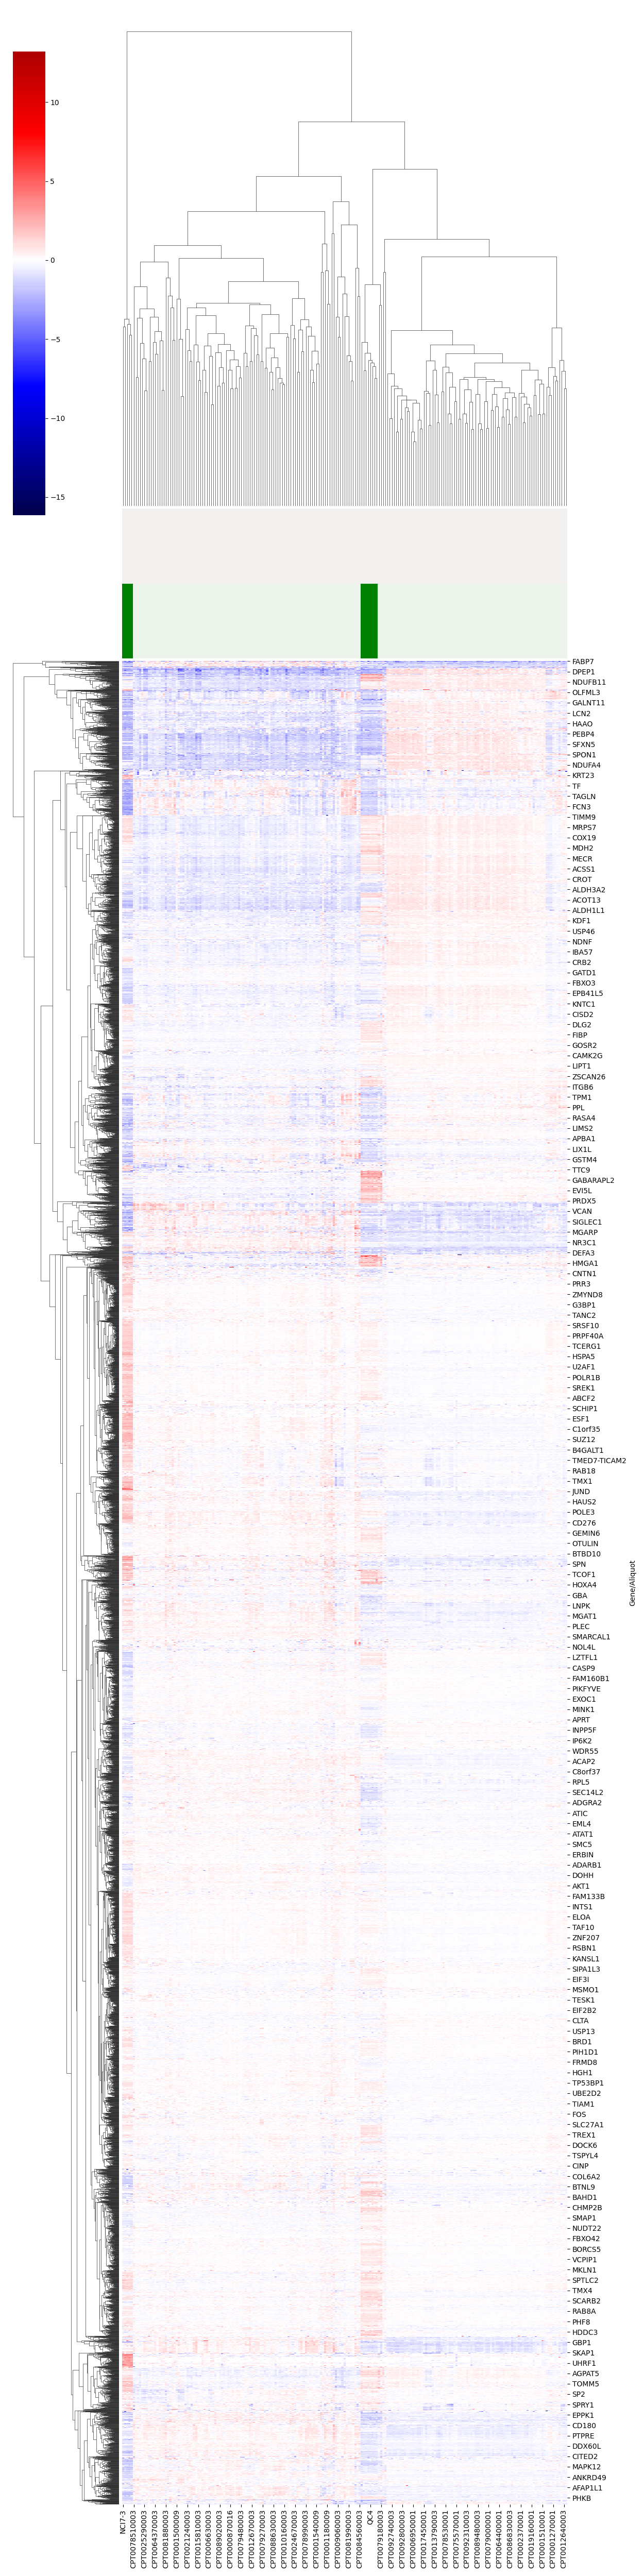

In [8]:
from IPython.display import Image
Image(filename='results/clustermap_processed_data.png')

Load in the clustermap for the standardized data: <!-- pragma: allowlist secret -->

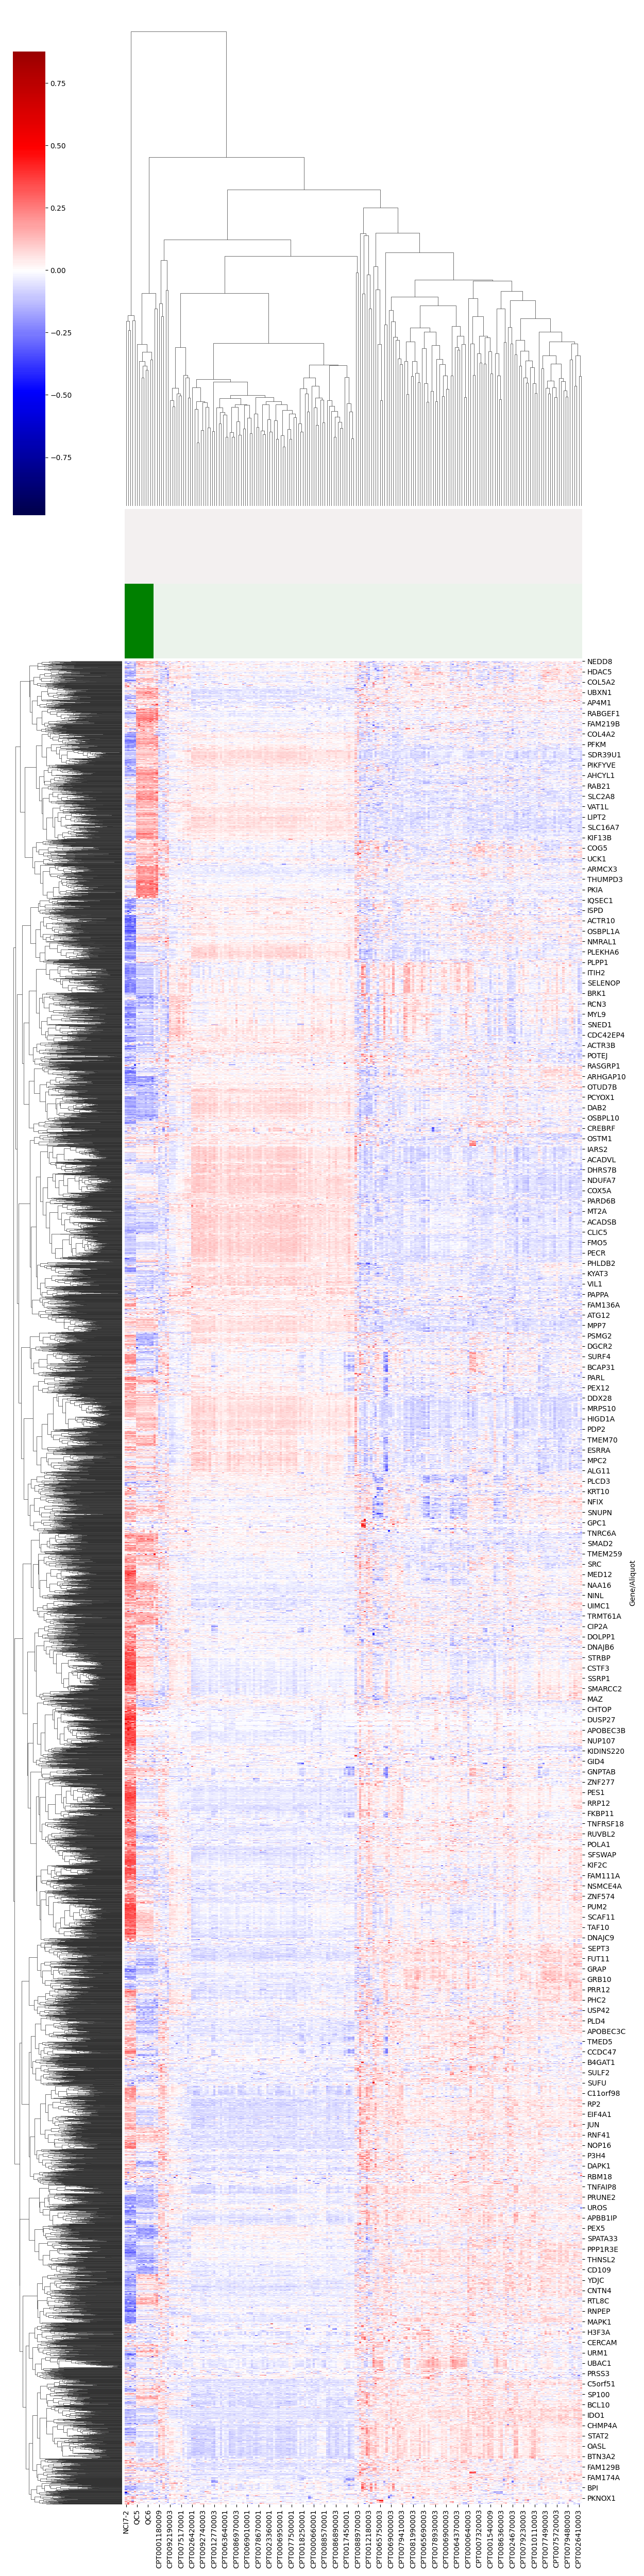

In [9]:
from IPython.display import Image
Image(filename='results/clustermap_transformed_data.png')

Load in the dataframe of processed data produced by the ProcessData process:

In [10]:
import pandas as pd

processed_data = pd.read_csv("results/processed_data.csv")
processed_data.head()

Gene/Aliquot  CPT0000640003  CPT0000660001  CPT0000780007  CPT0000790001  \
0         A1BG         1.0401        -0.8370         0.5803        -0.6064   
1         A1CF        -1.0913         0.0556        -0.4647         0.5539   
2          A2M         0.8438        -1.3295        -0.8262        -0.6975   
3         AAAS        -0.1501        -0.1593         0.0268         0.0378   
4         AACS        -0.8881        -0.1487        -0.5417         0.2910   

   CPT0000870016  CPT0000890001  CPT0001180009  CPT0001190001  CPT0001220008  \
0         0.1041        -0.1866        -0.7143        -0.3100         0.6129   
1         0.3555         0.4798        -0.3470        -0.1472         0.3500   
2         1.2140        -0.4180        -0.5647        -0.5371         1.1097   
3         0.0444         0.1004         0.2691         0.0066         0.0845   
4        -0.3251        -0.0668         0.3244         0.3472        -0.3794   

   ...  NCI7-4  NCI7-5     QC1     QC2     QC3     QC4     QC5     QC6  \
0  ... -1.8485 -1.7370 -1.1657 -1.0042 -1.1258 -1.0642 -1.0423 -1.0204   
1  ... -1.3741 -1.1999 -1.9917 -1.6901 -1.7759 -2.1722 -2.1297 -1.5970   
2  ... -2.8584 -2.6337 -0.7650 -0.8239 -0.7353 -0.7420 -0.7303 -0.7643   
3  ...  1.7525  1.3627 -0.0927 -0.1887  0.0349 -0.2330  0.0259 -0.0173   
4  ...  0.6680  0.9196  0.2545  0.2514  0.2308  0.2361  0.1962  0.2062   

      QC7     QC8  
0 -1.0951 -0.9996  
1 -1.6895 -2.1075  
2 -0.7210 -0.8130  
3 -0.1095 -0.0528  
4  0.2574  0.2334  

[5 rows x 208 columns]

Load in the dataframe of standardized data produced by the ZscoreTransformation process:

In [11]:
import pandas as pd

processed_data = pd.read_csv("results/transformed_data.csv")
processed_data.head()

Gene/Aliquot  CPT0000640003  CPT0000660001  CPT0000780007  CPT0000790001  \
0         A1BG       0.130247      -0.088179       0.076743      -0.061345   
1         A1CF      -0.079223       0.025629      -0.021938       0.071185   
2          A2M       0.089455      -0.104303      -0.059431      -0.047957   
3         AAAS      -0.058840      -0.061151      -0.014412      -0.011649   
4         AACS      -0.148612      -0.026274      -0.091298       0.046476   

   CPT0000870016  CPT0000890001  CPT0001180009  CPT0001190001  CPT0001220008  \
0       0.021331      -0.012496      -0.073901      -0.026855       0.080537   
1       0.053047       0.064411      -0.011177       0.007089       0.052544   
2       0.122460      -0.023039      -0.036118      -0.033657       0.113162   
3      -0.009992       0.004073       0.046442      -0.019485       0.000079   
4      -0.055461      -0.012724       0.052002       0.055775      -0.064445   

   ...    NCI7-4    NCI7-5       QC1       QC2       QC3       QC4       QC5  \
0  ... -0.205880 -0.192906 -0.126427 -0.107635 -0.121784 -0.114616 -0.112068   
1  ... -0.105077 -0.089152 -0.161540 -0.133967 -0.141811 -0.178042 -0.174156   
2  ... -0.240610 -0.220577 -0.053975 -0.059226 -0.051327 -0.051925 -0.050882   
3  ...  0.418997  0.321099 -0.044424 -0.068535 -0.012378 -0.079661 -0.014638   
4  ...  0.108852  0.150481  0.040437  0.039924  0.036516  0.037393  0.030791   

        QC6       QC7       QC8  
0 -0.109520 -0.118212 -0.107099  
1 -0.125456 -0.133912 -0.172127  
2 -0.053913 -0.050052 -0.058255  
3 -0.025488 -0.048644 -0.034403  
4  0.032445  0.040917  0.036946  

[5 rows x 208 columns]